In [1]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [8]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# 读取数据
df = pd.read_csv('../Dataset/imputed_selected_features_W.csv')
labels = df['W'].values
smiles_list = df['SMILES'].tolist()

# 将SMILES转为 4个描述符 + 2048位指纹
def smiles_to_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    descriptors = [
        Descriptors.MolWt(mol),          # 分子量
        Descriptors.MolLogP(mol),        # LogP
        Descriptors.NumHDonors(mol),     # 氢键供体数
        Descriptors.NumHAcceptors(mol)   # 氢键受体数
    ]
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprint_array = np.zeros((2048,))
    Chem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array)
    features = np.concatenate([descriptors, fingerprint_array])
    return features

# 生成特征
features = []
for smiles in smiles_list:
    feats = smiles_to_features(smiles)
    if feats is not None:
        features.append(feats)

features = np.array(features)
print(f"生成的特征维度: {features.shape}")  # 应该是 (样本数, 2052)


# 转换为numpy数组
features = np.array(features)

# 获取原始数据集中的其他特征（从第二列到倒数第二列）
additional_features = df.iloc[:, 1:-2].values

# 合并所有特征
all_features = np.hstack((features, additional_features))

# 标准化特征
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)








X = np.array(all_features)
y = labels

# 3️⃣ 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4️⃣ 模型训练（XGBoost）
model = XGBClassifier(
    n_estimators=79,
    max_depth=17,
    learning_rate=0.1248,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1,
    use_label_encoder=False
)
model.fit(X_scaled, y)

# 5️⃣ 保存模型和 scaler（统一用 scaler.joblib）
joblib.dump(model,   'reactivitywater_xgb_model.joblib')
joblib.dump(scaler,  'reactivitywater_scaler.joblib')
print("✅ Reactivity 模型已保存，输入维数：", X.shape[1])



生成的特征维度: (708, 2052)
✅ Reactivity 模型已保存，输入维数： 2133


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# 数据预处理
df = pd.read_csv('../Dataset/imputed_selected_features_W.csv')
labels = df['W'].values
smiles_list = df['SMILES'].tolist()


# 函数：将SMILES转换为分子描述符和指纹
def smiles_to_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # 提取描述符
    descriptors = [
        Descriptors.MolWt(mol),  # 分子量
        Descriptors.MolLogP(mol),  # LogP
        Descriptors.NumHDonors(mol),  # 氢键供体数量
        Descriptors.NumHAcceptors(mol)  # 氢键受体数量
    ]
    # 生成Morgan指纹
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprint_array = np.zeros((2048,))
    Chem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array)
    # 合并描述符和指纹
    features = np.concatenate([descriptors, fingerprint_array])
    return features

# 将SMILES转换为特征
features = []
for smiles in smiles_list:
    feature = smiles_to_features(smiles)
    if feature is not None:
        features.append(feature)

# 转换为numpy数组
features = np.array(features)

# 获取原始数据集中的其他特征（从第二列到倒数第二列）
additional_features = df.iloc[:, 1:-2].values

# 合并所有特征
all_features = np.hstack((features, additional_features))

# 标准化特征
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)







y = labels
X = np.array(all_features)
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=42)


In [3]:


# 额外特征（和你训练时做的一样）
additional = df.iloc[:, 1:-2].values
X_all = np.hstack((features, additional))

# 2️⃣ 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# 3️⃣ 全量训练 XGBoost
model = RandomForestClassifier(
        n_estimators=145,       # 可根据需要调节
        max_depth=44,           # 可调整，或设为 None
        min_samples_split=0.021984640895660577,
        random_state=42,
        n_jobs=-1               # 并行加速
    )
model.fit(X_scaled, labels)

# 4️⃣ 保存模型和标准化器
joblib.dump(model,   'reactivitywater_rf_model.joblib')
joblib.dump(scaler, './reactivitywater_scaler.joblib')

['reactivitywater_rf_model.joblib']

In [4]:
joblib.dump(scaler, './reactivitywater_scaler.joblib')

['./reactivitywater_scaler.joblib']

In [ ]:
{'n_estimators': 145, 'max_depth': 44, 'min_samples_split': 0.021984640895660577}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# 定义函数进行单次模型训练和评估（使用 Random Forest）
def train_evaluate_rf(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(
        n_estimators=145,       # 可根据需要调节
        max_depth=44,           # 可调整，或设为 None
        min_samples_split=0.021984640895660577,
        random_state=42,
        n_jobs=-1               # 并行加速
    )
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    return auc_score

# 原始标签的模型性能
original_auc = train_evaluate_rf(X_train, y_train, X_test, y_test)
print(f"Original AUC: {original_auc:.4f}")

# y-随机化测试
n_iterations = 2000
randomized_aucs = []

for i in tqdm(range(n_iterations), desc="随机标签 AUC 测试中"):
    np.random.shuffle(y_train)  # 打乱训练标签
    auc_score = train_evaluate_rf(X_train, y_train, X_test, y_test)
    randomized_aucs.append(auc_score)

# 计算随机化结果的统计信息
randomized_mean_auc = np.mean(randomized_aucs)
randomized_std_auc = np.std(randomized_aucs)
print(f"Randomized AUC (mean): {randomized_mean_auc:.4f}")
print(f"Randomized AUC (std): {randomized_std_auc:.4f}")



Original AUC: 0.8488


随机标签 AUC 测试中: 100%|██████████| 2000/2000 [12:01<00:00,  2.77it/s]

Randomized AUC (mean): 0.5564
Randomized AUC (std): 0.0880


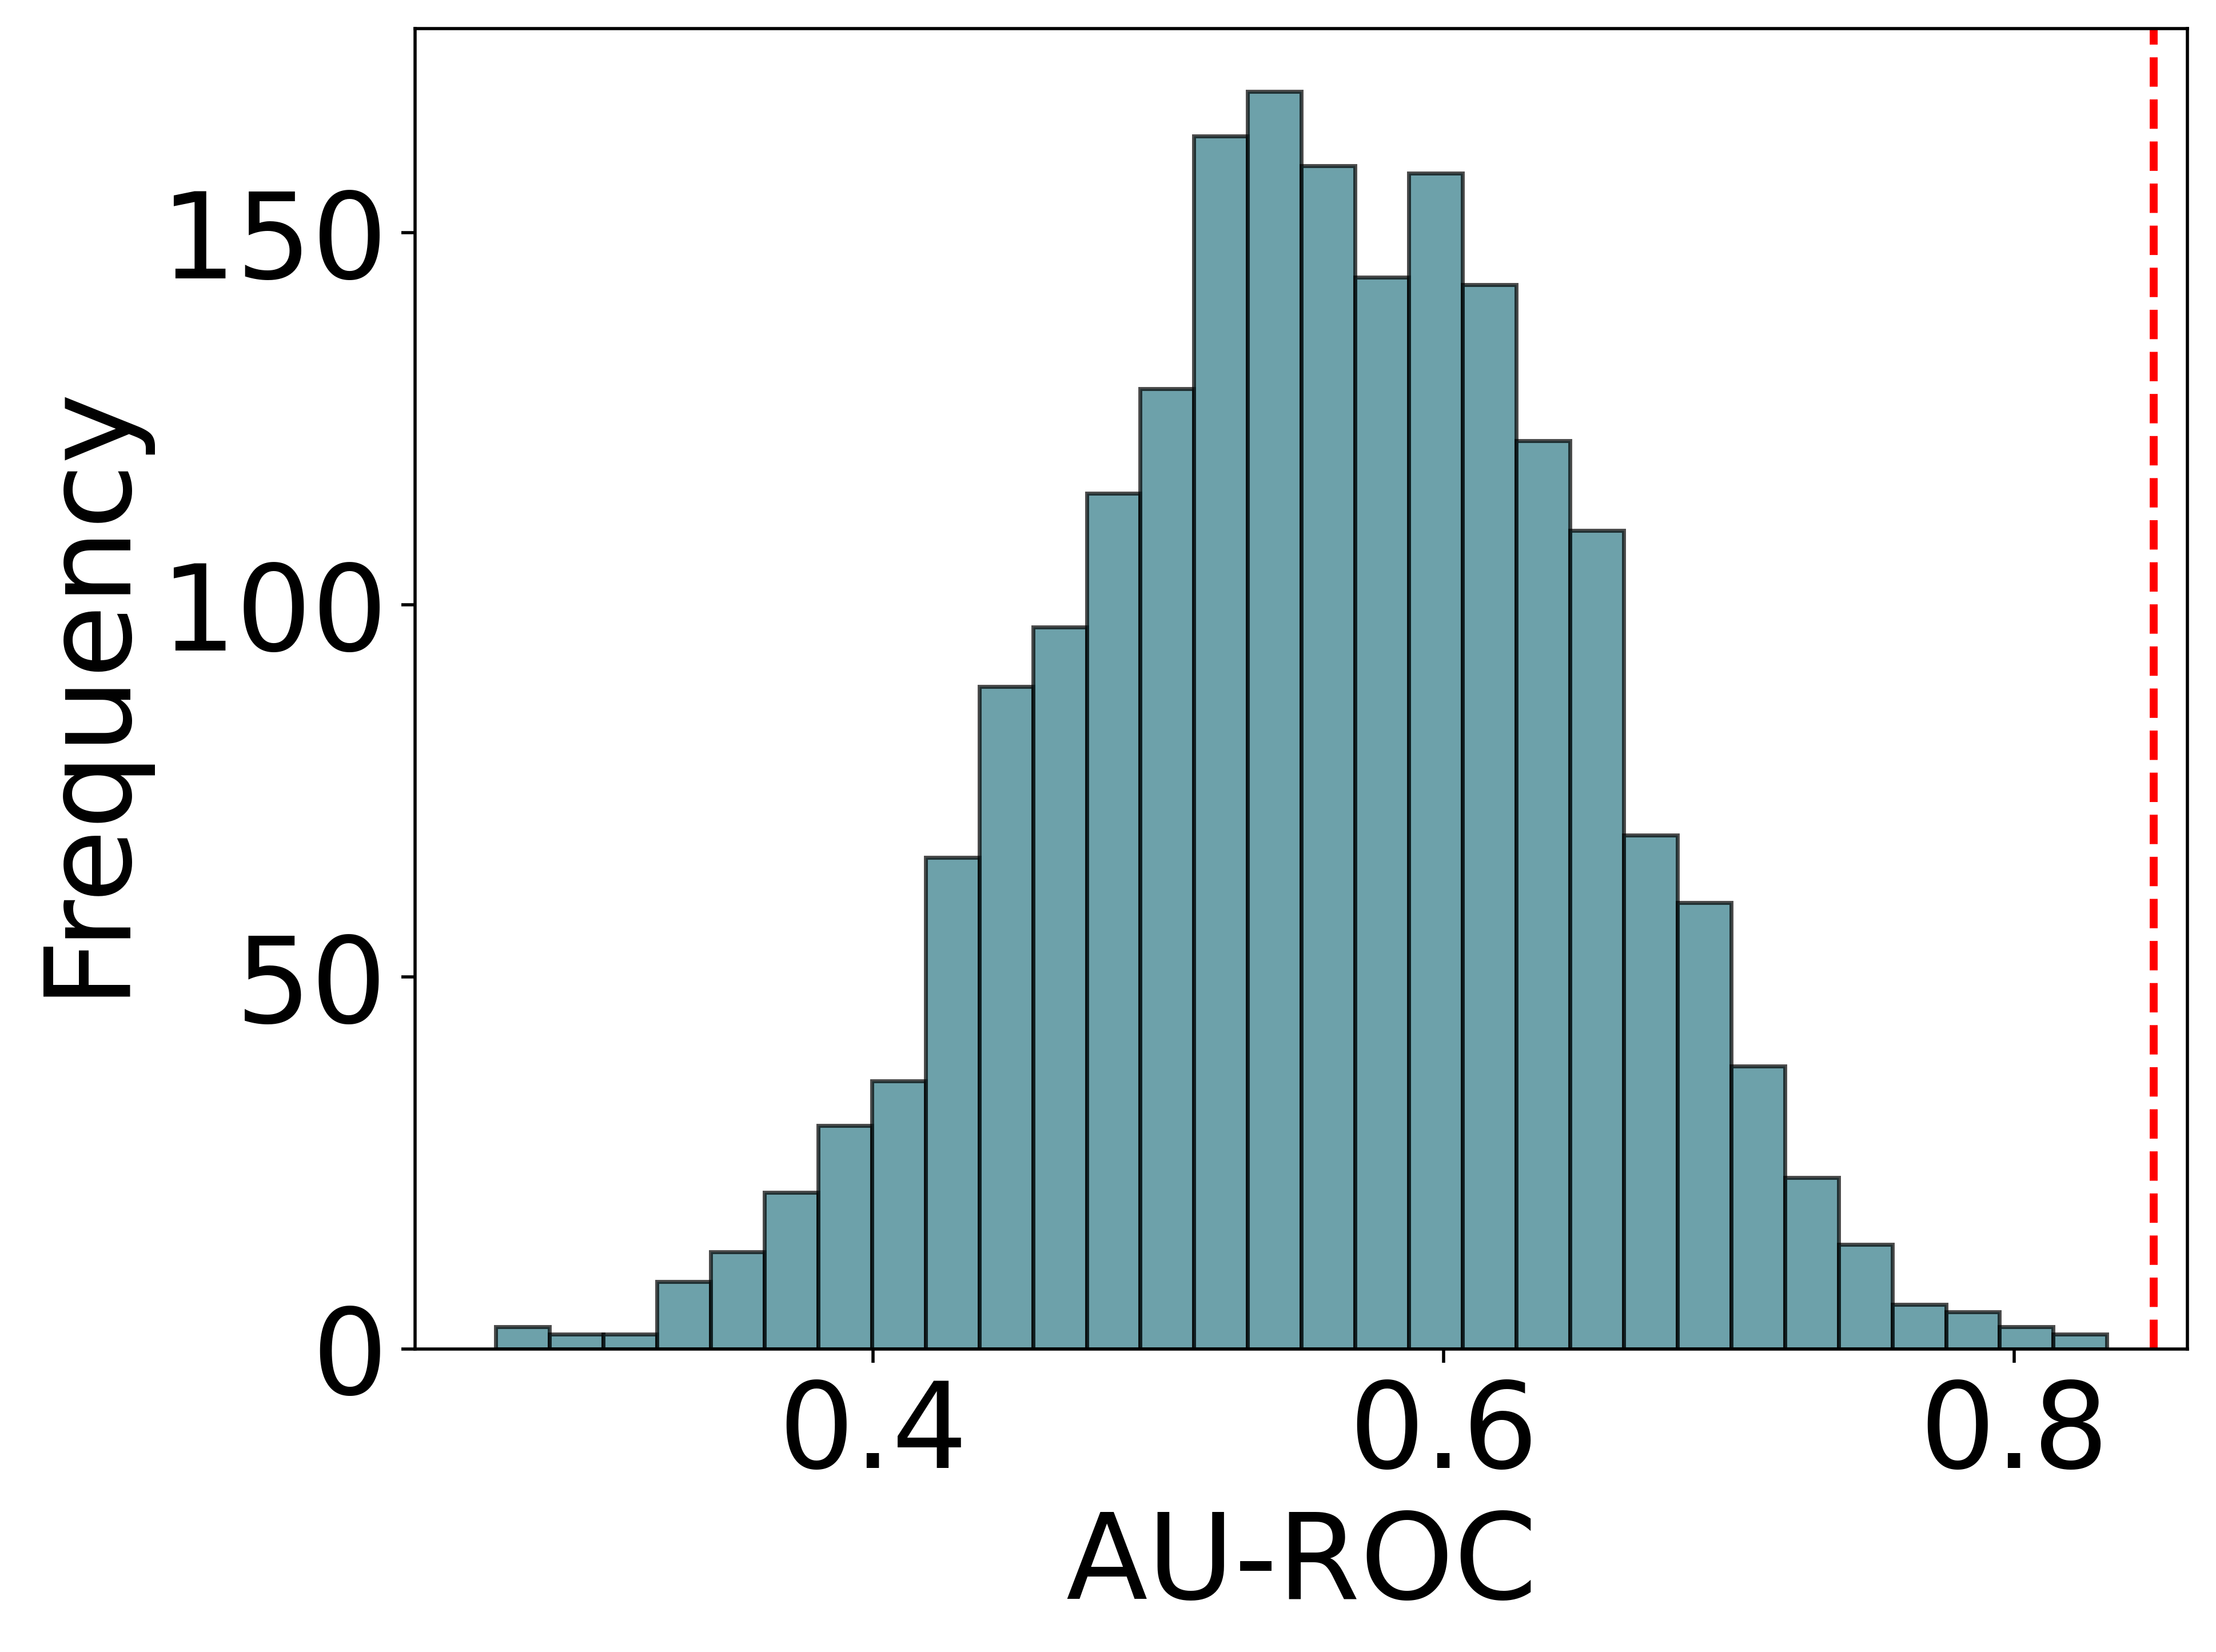

In [8]:
# 绘制AUC分布直方图
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=500)  # 设置更高的dpi，300 dpi一般会产生高质量的图像

plt.hist(randomized_aucs, bins=30, color='#2F7987', alpha=0.7, edgecolor='black')
plt.axvline(original_auc, color='red', linestyle='dashed', linewidth=2)


#plt.title("Distribution of AUC Scores from Y-Randomization",fontproperties=prop)
plt.xlabel("AU-ROC",fontsize=30)
plt.ylabel("Frequency", fontsize=30)

# 设置刻度字体大小
plt.tick_params(axis='both', labelsize=30)  # both表示x轴和y轴


# textstr = f"Randomized AUC (mean): {randomized_mean_auc:.4f}\nRandomized AUC (std): {randomized_std_auc:.4f}"
# plt.text(0.05, plt.ylim()[1]*0.9, textstr, fontsize=20, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))


#plt.legend()
plt.show()

In [9]:
np.save("./rf_reactivitywater_randomized_aucs.npy",randomized_aucs)
np.save("./rf_reactivitywater_original_auc.npy",original_auc)

In [10]:
import numpy as np

original_auc = np.load("./rf_reactivitywater_original_auc.npy")
randomized_aucs = np.load("./rf_reactivitywater_randomized_aucs.npy")


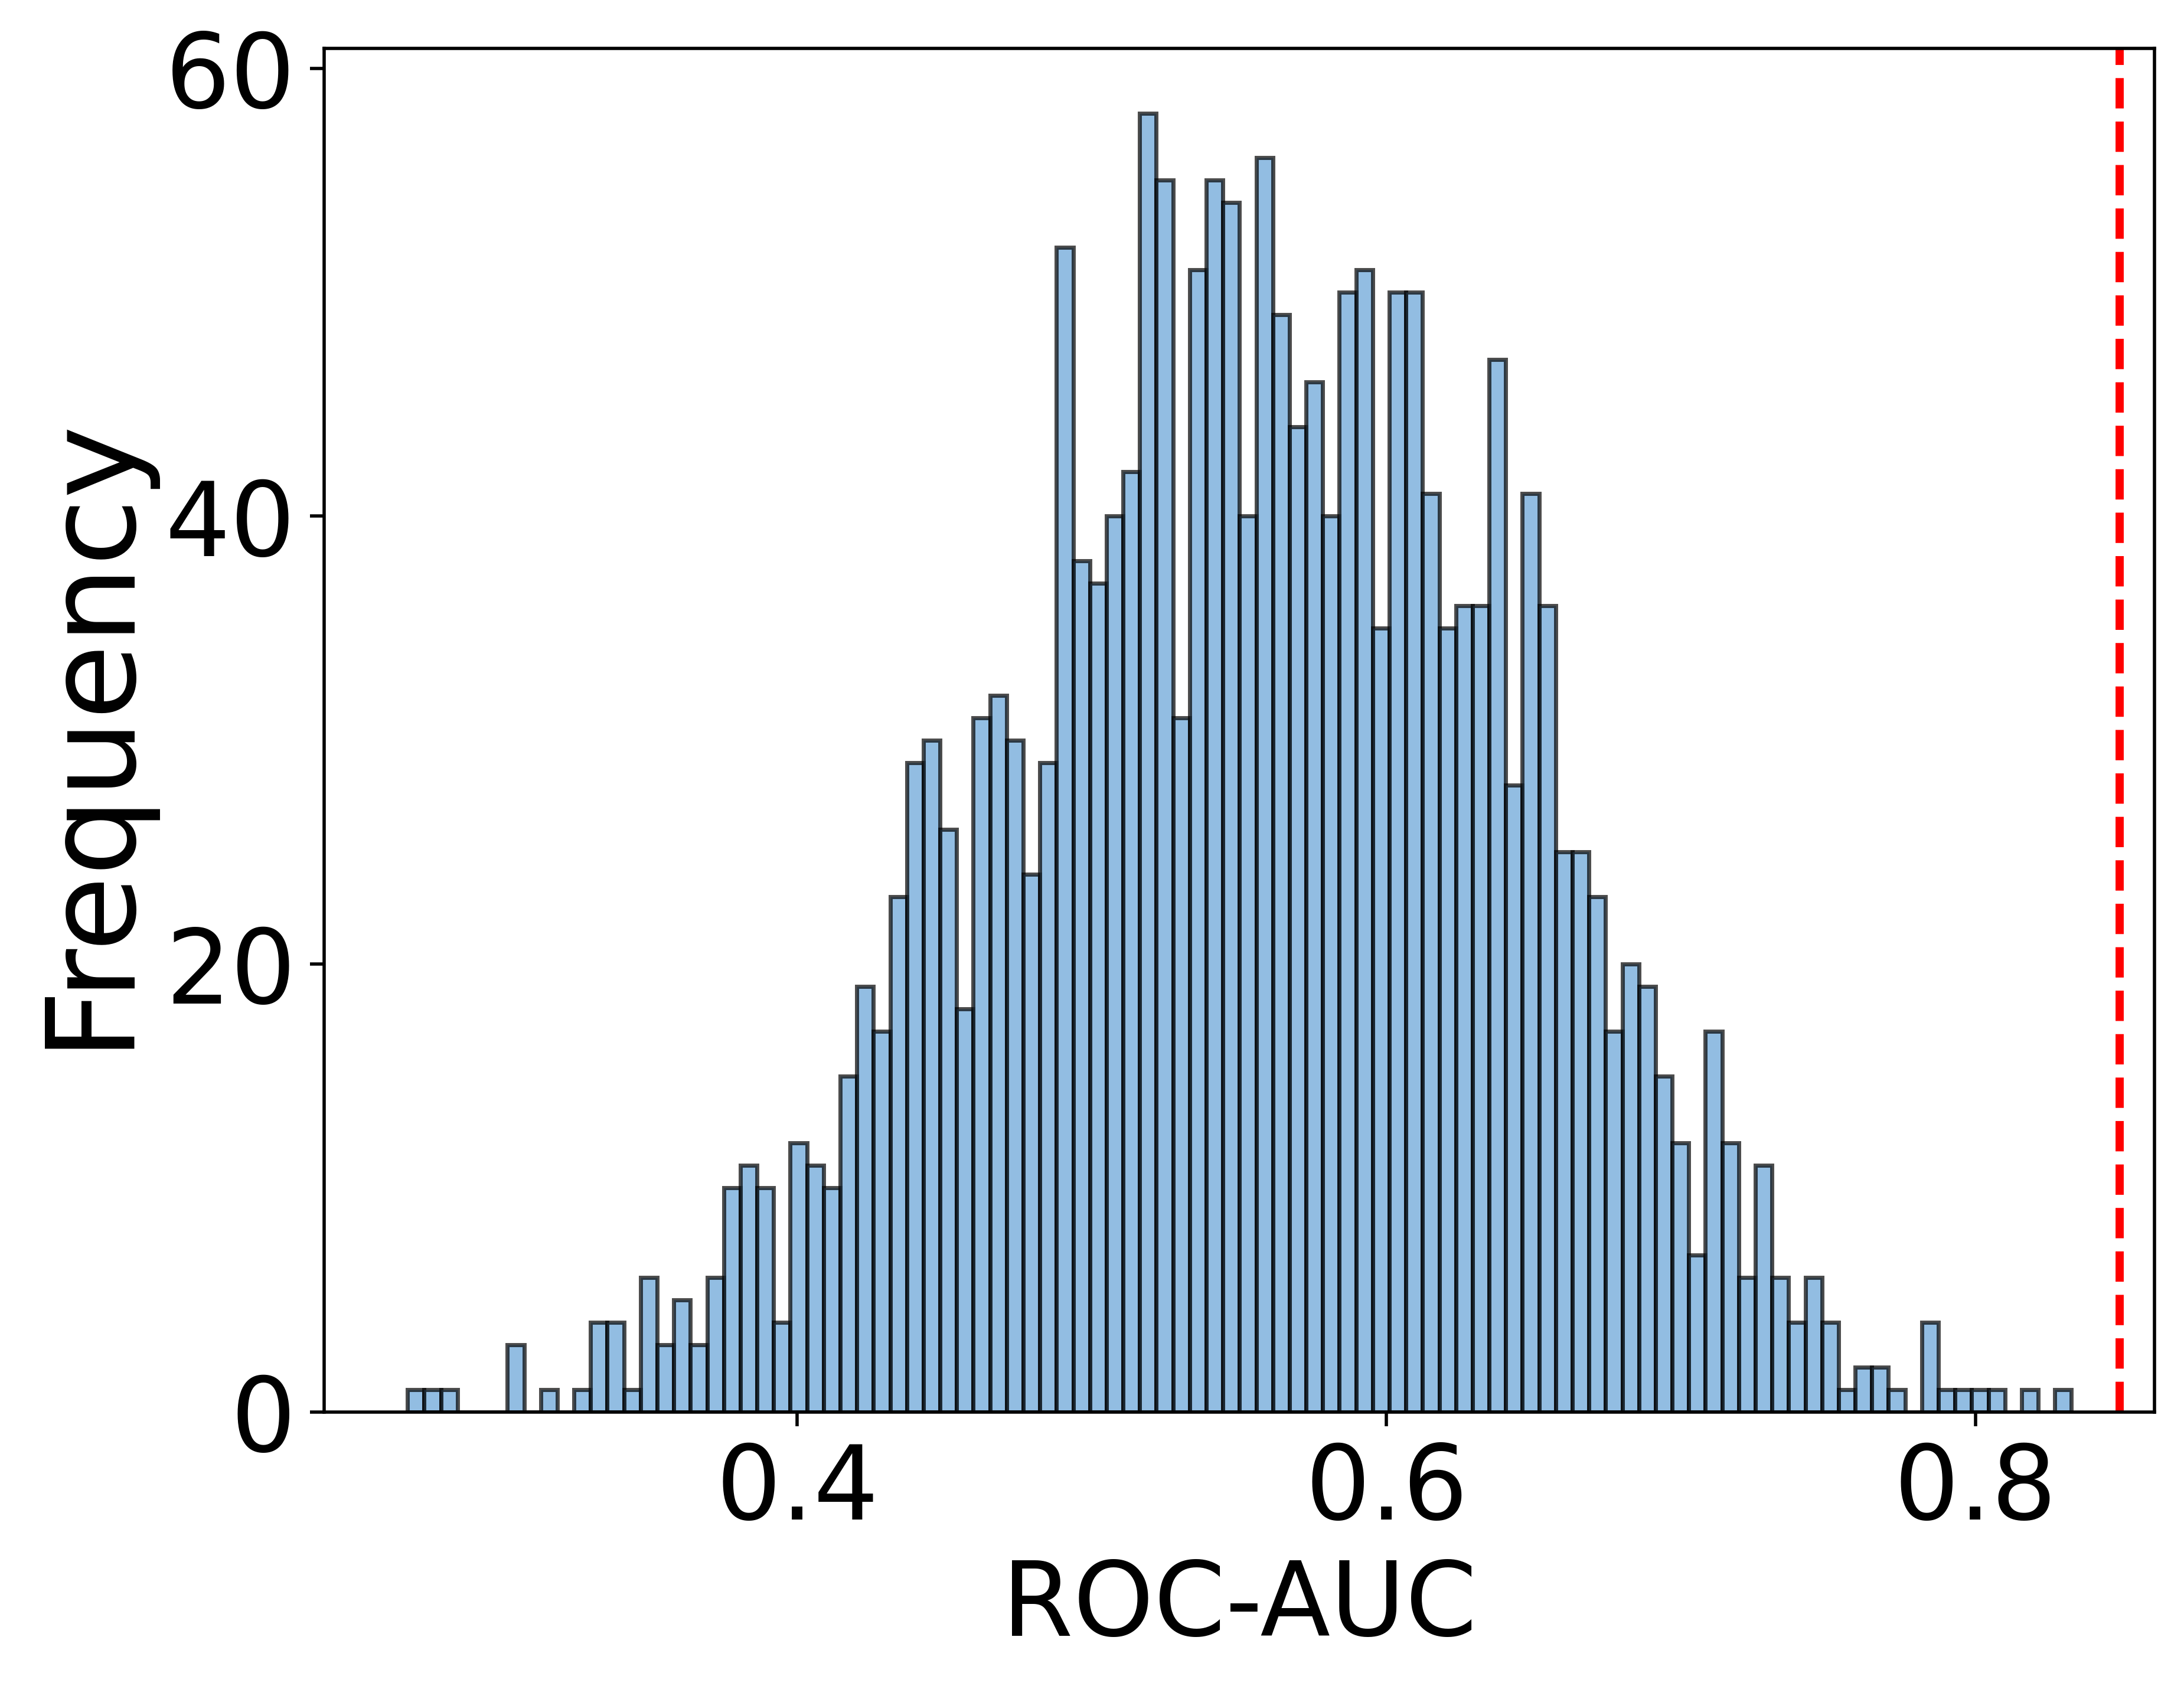

In [11]:
# 绘制AUC分布直方图
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=500)  # 设置更高的dpi，300 dpi一般会产生高质量的图像

plt.hist(randomized_aucs, bins=100, color='#64A2D7', alpha=0.7, edgecolor='black')
plt.axvline(original_auc, color='red', linestyle='dashed', linewidth=2)


#plt.title("Distribution of AUC Scores from Y-Randomization",fontproperties=prop)
plt.xlabel("ROC-AUC",fontsize=25)
plt.ylabel("Frequency", fontsize=30)

# 设置刻度字体大小
plt.tick_params(axis='both', labelsize=25)  # both表示x轴和y轴



#plt.legend()
plt.show()